In [1]:
from __future__ import print_function
from generate_data import simulate_data
import pandas as pd
from sbg_survival import SBGSurvival

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Getting Simulated Data

In [6]:
data = simulate_data(50000)
train, test, params = data['train'], data['test'], data['params']

In [8]:
train.head()

,id,category,counts,numerical,alpha_true,beta_true,age,alive
0,0,cat_a,1,0.037403,1.419717,1.843322,1,0
1,1,cat_a,0,1.004700,1.789613,2.142895,1,0
2,2,cat_a,0,0.457923,1.548398,2.147779,1,0
3,3,cat_b,1,1.040858,1.173999,1.344749,2,0
4,4,cat_c,0,1.274193,1.719272,4.884265,4,0


In [9]:
train.groupby('category').mean().drop('id', axis=1)

,counts,numerical,alpha_true,beta_true,age,alive
category,,,,,,
cat_a,0.248112,0.996412,1.851258,2.089107,2.704943,0.073807
cat_b,0.242278,0.996134,1.161682,1.514475,3.109529,0.120153
cat_c,0.247274,1.002677,1.667315,4.697594,4.323850,0.211949


In [10]:
train.groupby('counts').mean().drop('id', axis=1)

,numerical,alpha_true,beta_true,age,alive
counts,,,,,
0,0.993852,1.539680,2.395939,3.214707,0.120523
1,1.010668,1.658244,2.085240,2.846517,0.094103
2,1.009091,1.759019,1.767791,2.562284,0.069204
3,0.934652,1.893318,1.448034,1.891892,0.027027
4,0.804394,1.820618,0.971790,2.000000,0.000000


In [11]:
train[['numerical', 'alpha_true', 'beta_true', 'age', 'alive']].corr()

,numerical,alpha_true,beta_true,age,alive
numerical,1.000000,0.578718,0.024638,-0.099251,-0.081289
alpha_true,0.578718,1.000000,0.282236,-0.095737,-0.087987
beta_true,0.024638,0.282236,1.000000,0.178565,0.122258
age,-0.099251,-0.095737,0.178565,1.000000,0.773726
alive,-0.081289,-0.087987,0.122258,0.773726,1.000000


 # Creating and Training the Model

In [12]:
# START MODELING
# Create the sbs object using all features. Lets keep gamma small and let
# the model "overfit" if necessary. We have enough data.
feature_list = ['category', 'counts', 'numerical']

# something
sbs = SBGSurvival(age='age',
                  alive='alive',
                  features=feature_list,
                  gamma=1e-3,
                  verbose=True)

In [13]:
# Train model
sbs.fit(train)

Starting Optimization with parameters:
        Samples: 25000
  gamma (alpha): 0.001
   gamma (beta): 0.001
          Seeds: 1

Step  |    Time    | LogLikelihood |
-----------------------------------
    1 | 0:01:12.58 |     42930.032 |

Optimization completed:
             wa: [ 0.39228719  0.02477283  0.10811164  0.21300594 -0.20081052  0.13078899]
             wb: [ 0.68151295 -0.08576182 -0.04387036  0.07148288 -0.22453846  0.94164144]
  LogLikelihood: 42930.0324614
   Reg. Penalty: 0.00106659960282



In [14]:
sbs.summary()

,w_alpha,w_beta
bias,0.392287,0.681513
category_cat_a,0.213006,0.071483
category_cat_b,-0.200811,-0.224538
category_cat_c,0.130789,0.941641
counts,0.024773,-0.085762
numerical,0.108112,-0.043870


In [15]:
# Make some predictions
pred = pd.concat([test,
                  sbs.predict_params(test)], axis=1)

In [16]:
print("Mean Absolute Error for Alpha: "
      "{}".format((pred['alpha_true'] -
                   pred['alpha']).abs().mean()))

print("Mean Absolute Error for Beta:  "
      "{}".format((pred['beta_true'] -
                   pred['beta']).abs().mean()))

Mean Absolute Error for Alpha: 0.0646014930201
Mean Absolute Error for Beta:  0.149254437292


# Visualizing the Hazard Curve

In [17]:
# Predict survival curves
harz_raw = sbs.predict_churn(test, age=1, n_periods=24)

harz_curve = pd.concat([test[feature_list], 
                        harz_raw], axis=1)

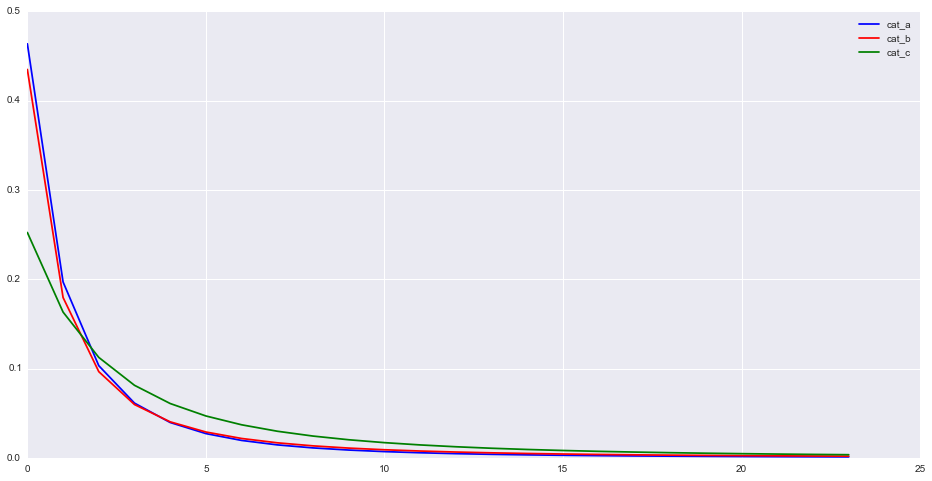

In [18]:
f, axis = plt.subplots(1, 1, figsize=(16, 8))

col_map = {'cat_a': 'b', 'cat_b': 'r', 'cat_c': 'g'}

for name, df in harz_curve.groupby('category'):
    axis.plot(df.iloc[:, 3:].mean(), alpha=1, c=col_map[name], label=name)

plt.legend()

# Visualizing the Retention Curve

In [19]:
# Predict survival curves
sc_raw = sbs.predict_survival(test, n_periods=24)

surv_curv = pd.concat([test[feature_list], 
                       sc_raw], axis=1)

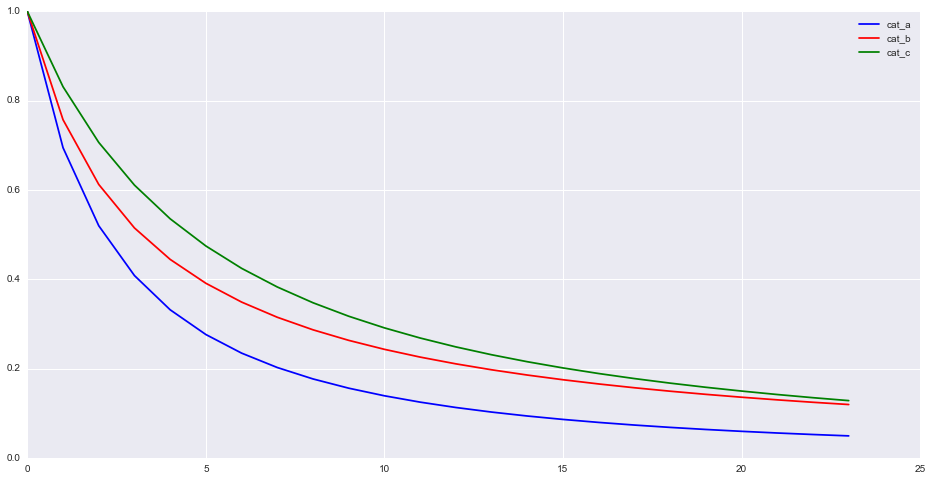

In [20]:
f, axis = plt.subplots(1, 1, figsize=(16, 8))

col_map = {'cat_a': 'b', 'cat_b': 'r', 'cat_c': 'g'}

for name, df in surv_curv.groupby('category'):
    axis.plot(df.iloc[:, 3:].mean(), alpha=1, c=col_map[name], label=name)
        


plt.legend()

# Life-Time-Value

### Initial LTV

In [21]:
ltv_initial = sbs.predict_ltv(test, age=1, alive=1, arpu=10, discount_rate=0.005)

In [22]:
test['ltvi'] = ltv_initial

### Residual LTV

In [23]:
ltv_residual = sbs.predict_ltv(test, age=None, alive=None, arpu=10, discount_rate=0.005)

In [24]:
test['ltvr'] = ltv_residual

### Relation with number of counts

In [25]:
test.groupby(['counts']).mean()

,id,numerical,alpha_true,beta_true,age,alive,ltvi,ltvr
counts,,,,,,,,
0,37503.698707,1.003647,1.552355,2.409891,3.194604,0.121204,40.023569,19.646840
1,37515.968467,1.000068,1.650937,2.080995,2.837181,0.090684,31.035398,13.160020
2,37278.084034,0.976663,1.746233,1.764052,2.615126,0.065546,23.632363,8.995775
3,37294.418182,0.993394,1.861917,1.455741,2.472727,0.090909,17.996750,11.374362
4,28129.000000,1.285964,2.012519,1.786206,1.000000,0.000000,16.783910,0.000000


### Correlation with alpha and beta parameters

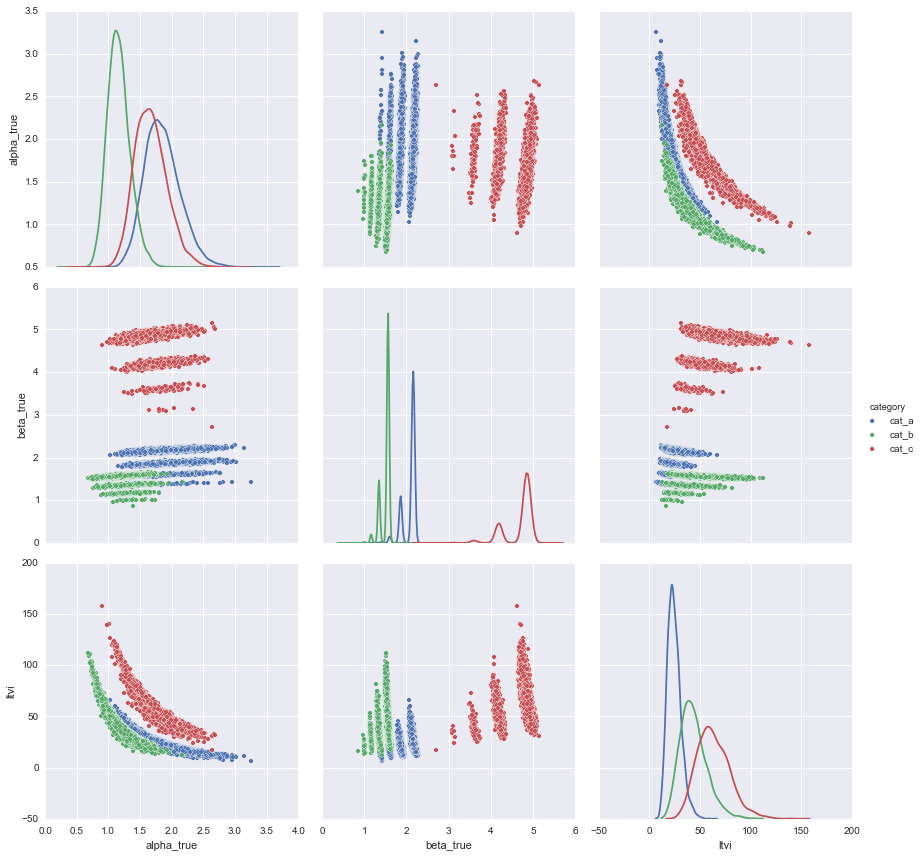

In [26]:
sns.pairplot(test, vars=['alpha_true', 'beta_true', 'ltvi'], hue='category', diag_kind='kde', size=4)